Reference:
* Bootstrap sampling applied to image analysis
* [Hu moment in OpenCV](https://www.learnopencv.com/shape-matching-using-hu-moments-c-python/)

In [1]:
using Images, TestImages, Colors # load image
using Random, Distributions # normal etc
using Plots # basic plot
using ImageFiltering
using Random, Distributions
using Printf

using ImageSegmentation
using Random
using LinearAlgebra

ArgumentError: ArgumentError: Package ImageSegmentation not found in current path:
- Run `import Pkg; Pkg.add("ImageSegmentation")` to install the ImageSegmentation package.


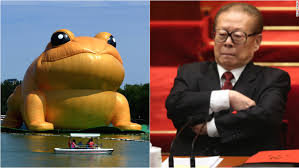

In [2]:
img = load("toad_and_jiang.jpg") # require package `ImageMagick`, 
#related to some shit problems: https://github.com/JuliaIO/ImageMagick.jl/issues/133

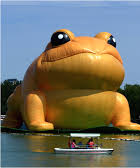

In [3]:
simg = img[1:size(img,1),1:140]

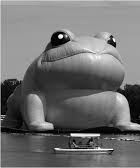

In [4]:
toad = Gray.(simg)

In [5]:
# I know that there're many redundancy computation. But
# premature optimization is the root of all evil

function hu_M(arr,i,j)
    # arr: [[ii_1,jj_1,I_1],[ii_2,jj_2,I_2],...]
    return sum(arr[:,1].^i .* arr[:,2].^j .* arr[:,3])
end

function hu_mu(arr,i,j)
    M00 = hu_M(arr, 0, 0)
    M10 = hu_M(arr, 1, 0)
    M01 = hu_M(arr, 0, 1)
    
    x_bar = M10/M00
    y_bar = M01/M00
    
    return sum((arr[:,1].-x_bar).^i .* (arr[:,2].-y_bar).^j .* arr[:,3])
end

function hu_eta(arr, i, j)
    mu00 = hu_mu(arr, 0, 0)
    return hu_mu(arr, i, j)/mu00^((i+j)/2+1)
end

function hu_hu(arr)
    eta20 = hu_eta(arr, 2, 0)
    eta02 = hu_eta(arr, 0, 2)
    eta11 = hu_eta(arr, 1, 1)
    eta12 = hu_eta(arr, 1, 2)
    eta21 = hu_eta(arr, 2, 1)
    eta30 = hu_eta(arr, 3, 0)
    eta03 = hu_eta(arr, 0, 3)
    
    mu03 = hu_mu(arr, 0, 3)
    
    hu1 = eta20+eta02
    hu2 = (eta20-eta02)^2 + 4*eta11^2
    #hu3 = (eta30-3*eta12)^2 + (3*eta21-mu03)^2
    #hu4 = (eta30+eta12)^2 + (eta21+mu03)^2
    hu3 = (eta30-3*eta12)^2 + (3*eta21-eta03)^2
    hu4 = (eta30+eta12)^2 + (eta21+eta03)^2
    hu5 = (eta30-3*eta12)*(eta30+eta12)*((eta30+eta12)^2-3*(eta21+eta03)^2) + (3*eta21-eta03)*(eta21+eta03)*(3*(eta30+eta12)^2-(eta21+eta03)^2)
    hu6 = (eta20-eta02)*((eta30+eta12)^2-(eta21+eta03)^2)+4*eta11*(eta30+eta12)*(eta21+eta03)
    hu7 = (3*eta21-eta03)*(eta30+eta12)*((eta30+eta12)^2-3*(eta21+eta03)^2)-(eta30-3*eta12)*(eta21+eta03)*(3*(eta30+eta12)^2-(eta21+eta03))
    return [hu1,hu2,hu3,hu4,hu5,hu6,hu7]
end

hu_hu (generic function with 1 method)

In [6]:
IJI_arr = zeros(prod(size(toad)), 3)

for i in 1:size(toad,1)
    for j in 1:size(toad,2)
        idx = (i-1)*size(toad,2)+j
        IJI_arr[idx,1] = i
        IJI_arr[idx,2] = j
        IJI_arr[idx,3] = toad[i,j]
    end
end

In [7]:
size(IJI_arr)

(23520, 3)

In [8]:
IJI_arr[1:5,:]

5×3 Array{Float64,2}:
 1.0  1.0  0.890196
 1.0  2.0  0.756863
 1.0  3.0  0.752941
 1.0  4.0  0.780392
 1.0  5.0  0.776471

In [9]:
hu_M(IJI_arr,1,1)

5.5848498964705884e7

In [10]:
hu_mu(IJI_arr,1,1)

818525.240650807

In [11]:
hu_eta(IJI_arr,1,1)

0.007621735069615235

In [12]:
hu_hu(IJI_arr)

7-element Array{Float64,1}:
 0.3992827655162117   
 0.0057626119262236455
 0.0023228973168189287
 0.002208385724667927 
 3.892849854566733e-6 
 0.0001395202263626585
 7.060881377753598e-6 

In [13]:
log.(hu_hu(IJI_arr))

7-element Array{Float64,1}:
  -0.9180854275869763
  -5.15636444764216  
  -6.064940029003845 
  -6.11549347168145  
 -12.456369058133477 
  -8.877300975366142 
 -11.860940673209532 

In [14]:
IJI_arr_255 = copy(IJI_arr)
IJI_arr_255[:,3] *= 255
hu_hu(IJI_arr_255)

7-element Array{Float64,1}:
 0.0015658147667302427 
 8.862148291001379e-8  
 1.4009075343986417e-10
 1.331847162655636e-10 
 1.4158804033547694e-20
 3.2997151478610955e-14
 5.755372431661896e-17 

Comparing Python OpenCV:

```
moments = cv2.moments(toad)
huMoments = cv2.HuMoments(moments)

array([[ 1.56579628e-03],
       [ 8.86281951e-08],
       [ 1.40100345e-10],
       [ 1.33194012e-10],
       [ 1.41611004e-20],
       [ 3.30017736e-14],
       [-1.14242293e-20]])
```

It seems correct.

and left-top result:
```
array([[1.09256394e-03],
       [4.83178828e-08],
       [3.51588466e-13],
       [6.47986624e-14],
       [9.60769908e-27],
       [7.32622785e-19],
       [1.83102143e-27]])
```

In [15]:
log.(hu_hu(IJI_arr_255))

7-element Array{Float64,1}:
  -6.459348972745402
 -16.238891537959013
 -22.688730664479124
 -22.739284107156738
 -45.70395032908406 
 -31.04235515599986 
 -37.393812826368446

In [16]:
n_sample = 100
mat = zeros(n_sample,7)
for t=1:n_sample
    N = prod(size(toad))
    n= N
    p = rand(1:n, n)
    mat[t,:] = log.(hu_hu(IJI_arr_255[p,:]))
end

In [17]:
mean(mat,dims=1)

1×7 Array{Float64,2}:
 -6.45952  -16.2429  -22.6849  -22.7418  -45.7139  -31.0482  -37.3988

In [18]:
std(mat,dims=1)

1×7 Array{Float64,2}:
 0.00524178  0.0518707  0.0758691  0.0488104  0.116031  0.0676896  0.220568

In [19]:
n_sample = 100
mat = zeros(n_sample,7)
for t=1:n_sample
    N = prod(size(toad))
    n= N
    p = rand(1:n, n)
    mat[t,:] = log.(hu_hu(IJI_arr_255[p,:]))
end

In [20]:
mean(mat,dims=1)

1×7 Array{Float64,2}:
 -6.45938  -16.2332  -22.6814  -22.7357  -45.7007  -31.0422  -37.4211

In [21]:
std(mat,dims=1)

1×7 Array{Float64,2}:
 0.00639939  0.0506825  0.07046  0.0523681  0.115216  0.0740558  0.25303

In [22]:
n_sample = 100
mat = zeros(n_sample,7)
for t=1:n_sample
    N = prod(size(toad))
    n= Int(floor(N / 10))
    p = rand(1:N, n)
    #println((N/n)*hu_hu(IJI_arr_255[p,:]))
    mat[t,:] = log.((N/n)*hu_hu(IJI_arr_255[p,:]))
end

In [23]:
mean(mat,dims=1)

1×7 Array{Float64,2}:
 -1.85601  -9.33962  -13.4992  -13.5403  -29.6357  -19.5609  -24.8363

In [24]:
std(mat,dims=1)

1×7 Array{Float64,2}:
 0.0191359  0.162551  0.234748  0.151038  0.348386  0.201469  0.661337

In [25]:
n_sample = 100
mat = zeros(n_sample,7)
for t=1:n_sample
    N = prod(size(toad))
    n= Int(floor(N / 10))
    p = rand(1:N, n)
    mat[t,:] = log.((N/n)*hu_hu(IJI_arr_255[p,:]))
end

In [26]:
mean(mat,dims=1)

1×7 Array{Float64,2}:
 -1.85451  -9.30996  -13.5121  -13.5188  -29.644  -19.5325  -24.9626

In [27]:
std(mat,dims=1)

1×7 Array{Float64,2}:
 0.0163853  0.16162  0.214889  0.166798  0.444099  0.229867  1.15017

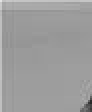

In [28]:
lefttop = toad[1:Int(div(size(toad,1),3)), 1:Int(div(size(toad,2),3))]

In [29]:
function get_arr(toad)
    IJI_arr = zeros(prod(size(toad)), 3)

    for i in 1:size(toad,1)
        for j in 1:size(toad,2)
            idx = (i-1)*size(toad,2)+j
            IJI_arr[idx,1] = i
            IJI_arr[idx,2] = j
            IJI_arr[idx,3] = toad[i,j]
        end
    end
    
    IJI_arr[:,3] *= 255
    return IJI_arr
end

function get_mat(IJI_arr; n_sample = 100, factor = 1)
    mat = zeros(n_sample,7)
    for t=1:n_sample
        N = size(IJI_arr, 1)
        n= Int(floor(N / factor))
        p = rand(1:N, n)
        mat[t,:] = (N/n)*hu_hu(IJI_arr[p,:])
    end
    return mat
end

get_mat (generic function with 1 method)

In [30]:
log.(get_mat(get_arr(lefttop), factor=1)[:,1:4])

100×4 Array{Float64,2}:
 -6.80967  -16.6503  -29.4249  -29.1422
 -6.83993  -16.8704  -27.6391  -32.3041
 -6.8112   -16.6502  -27.8377  -31.0537
 -6.81126  -16.8943  -27.8342  -30.3185
 -6.81215  -16.8447  -27.5335  -30.0175
 -6.83691  -16.8126  -27.9703  -31.0166
 -6.83946  -16.9992  -27.9302  -27.8958
 -6.82423  -16.9243  -27.9233  -27.472 
 -6.79944  -16.6616  -27.3976  -30.1755
 -6.83766  -17.202   -29.6682  -28.5709
 -6.83917  -17.0741  -33.5611  -27.171 
 -6.81069  -16.6315  -30.687   -27.799 
 -6.82103  -16.923   -29.4162  -28.7187
  ⋮                                    
 -6.83551  -17.1121  -26.8827  -28.1282
 -6.82083  -16.8631  -32.5071  -29.9922
 -6.83547  -16.9057  -26.9246  -30.462 
 -6.83884  -17.1062  -29.4128  -30.5565
 -6.81047  -16.7754  -26.8069  -27.8278
 -6.79954  -16.865   -25.9878  -27.817 
 -6.8177   -16.9341  -28.4362  -29.6528
 -6.81014  -16.8903  -30.2891  -29.1038
 -6.82994  -16.7177  -27.3699  -28.2265
 -6.81878  -16.699   -27.6492  -27.5228
 -6.84164  -16.8

In [31]:
mean(log.(get_mat(get_arr(lefttop), factor=1)[:,1:4]), dims=1)

1×4 Array{Float64,2}:
 -6.81996  -16.8387  -27.5749  -29.0134

In [32]:
std(log.(get_mat(get_arr(lefttop), factor=1)[:,1:4]), dims=1)

1×4 Array{Float64,2}:
 0.0123502  0.127821  1.16092  1.41022

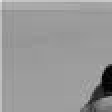

In [33]:
s = Int(div(size(toad,1),3))
lefttop = toad[1:s, 1:s]


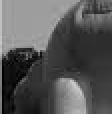

In [34]:
leftcenter = toad[s:s*2,1:s]


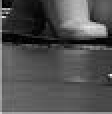

In [35]:
leftbottom  =toad[s*2:s*3,1:s]

In [36]:
function extract_hu4(patch)
    return log.(get_mat(get_arr(patch), factor=1)[:,1:4])
end

function extract_hu4_det(patch)
    return hu_hu(get_arr(patch))
end

extract_hu4_det (generic function with 1 method)

In [37]:
lefttop_hu = extract_hu4(lefttop)
leftcenter_hu = extract_hu4(leftcenter)
leftbottom_hu = extract_hu4(leftbottom)
;

In [38]:
mean(lefttop_hu, dims=1),std(lefttop_hu, dims=1)

([-6.83035 -19.1441 -25.586 -29.3213], [0.0126254 0.603314 0.503548 1.18738])

In [39]:
mean(leftcenter_hu, dims=1),std(leftcenter_hu, dims=1)

([-6.2298 -15.077 -21.2845 -22.1986], [0.0164721 0.114695 0.144104 0.191837])

In [40]:
mean(leftbottom_hu, dims=1),std(leftbottom_hu, dims=1)

([-6.13475 -15.3622 -21.7162 -23.9601], [0.0145904 0.154203 0.211139 0.29074])

In [41]:
log.(extract_hu4_det(lefttop)[1:4])

4-element Array{Float64,1}:
  -6.8294471219240656
 -19.129161412492994 
 -25.568368931487676 
 -30.647451085939892 

In [42]:
log.(extract_hu4_det(leftcenter)[1:4])

4-element Array{Float64,1}:
  -6.2285704128372466
 -15.068614704364027 
 -21.29280810416969  
 -22.184275042976726 

In [43]:
log.(extract_hu4_det(leftbottom)[1:4])

4-element Array{Float64,1}:
  -6.135696454516388
 -15.384917064725064
 -21.72958861347641 
 -23.9696596103768  

In [44]:
mean(extract_hu4(lefttop),dims=1)

1×4 Array{Float64,2}:
 -6.83042  -19.1445  -25.6112  -29.5493

In [45]:
mean(extract_hu4(leftcenter),dims=1)

1×4 Array{Float64,2}:
 -6.22825  -15.0612  -21.3073  -22.1838

In [46]:
mean(extract_hu4(leftbottom),dims=1)

1×4 Array{Float64,2}:
 -6.13732  -15.3933  -21.688  -23.9524

In [47]:
std(extract_hu4(lefttop),dims=1)

1×4 Array{Float64,2}:
 0.0124823  0.466662  0.475452  1.10995

In [48]:
std(extract_hu4(leftcenter),dims=1)

1×4 Array{Float64,2}:
 0.0163152  0.121269  0.141911  0.185269

In [49]:
std(extract_hu4(leftbottom),dims=1)

1×4 Array{Float64,2}:
 0.0130754  0.160368  0.198306  0.28447

In [50]:
mean(extract_hu4(lefttop) .- extract_hu4(leftcenter), dims=1)

1×4 Array{Float64,2}:
 -0.603073  -4.12007  -4.35035  -6.87468

In [51]:
std(extract_hu4(lefttop) .- extract_hu4(leftcenter), dims=1)

1×4 Array{Float64,2}:
 0.0179609  0.613325  0.567376  1.24016

In [52]:
mean(extract_hu4(leftcenter) .- extract_hu4(leftbottom), dims=1)

1×4 Array{Float64,2}:
 -0.0946006  0.315264  0.430147  1.75152

In [53]:
std(extract_hu4(leftcenter) .- extract_hu4(leftbottom), dims=1)

1×4 Array{Float64,2}:
 0.0223125  0.236521  0.283904  0.324502

In [54]:
mean(sum((extract_hu4(leftcenter) .- extract_hu4(leftbottom)).^2,dims=2), dims=1)

1×1 Array{Float64,2}:
 3.485081968641509

In [55]:
std(sum((extract_hu4(lefttop) .- extract_hu4(leftcenter)).^2,dims=2), dims=1)

1×1 Array{Float64,2}:
 28.452690181719557

In [56]:
mean(sum((extract_hu4(lefttop) .- extract_hu4(leftcenter)).^2,dims=2), dims=1)

1×1 Array{Float64,2}:
 88.05135123736565

In [57]:
std(sum((extract_hu4(lefttop) .- extract_hu4(leftcenter)).^2,dims=2), dims=1)

1×1 Array{Float64,2}:
 22.894793954440622

In [58]:
seg = 3
si = Int(div(size(toad,1), seg))
sj = Int(div(size(toad,2), seg))
f_mat = zeros(seg, seg, 100, 4)
for i in 1:seg
    for j in 1:seg
        patch = toad[1+(i-1)*si:i*si,1+(j-1)*sj:j*sj]
        f_mat[i,j,:,:] = extract_hu4(patch)
        #dis = sum((extract_hu4(leftcenter) .- extract_hu4(leftbottom)).^2,dims=2)
    end
end

In [59]:
using PyPlot

ArgumentError: ArgumentError: Package PyPlot not found in current path:
- Run `import Pkg; Pkg.add("PyPlot")` to install the PyPlot package.


In [60]:
imshow(convert(Array{Float64}, toad))

UndefVarError: UndefVarError: imshow not defined

In [61]:
fig, axs = subplots(seg,seg)
for i=1:seg
    for j=1:seg
        patch = toad[1+(i-1)*si:i*si,1+(j-1)*sj:j*sj]
        axs[i,j].imshow(convert(Array{Float64}, patch), cmap="gray")
    end
end

UndefVarError: UndefVarError: subplots not defined

In [62]:
imshow(convert(Array{Float64}, lefttop), cmap="gray")
axis("off")

UndefVarError: UndefVarError: imshow not defined

In [63]:
#=
for i=1:seg
    for j=1:seg
        patch = toad[1+(i-1)*si:i*si,1+(j-1)*sj:j*sj]
        imshow(convert(Array{Float64}, patch), cmap="gray")
        axis("off")
        PyPlot.savefig("images/toad_$(i)_$(j).png")
        clf()
    end
end
=#

In [64]:
#println("start")
for i=1:seg
    for j=1:seg
        if (j+1<=seg)
            d = sum((f_mat[i,j,:,:] .- f_mat[i,j+1,:,:]).^2,dims=2)
            mean_d = @sprintf("%.3f",mean(d))
            std_d = @sprintf("%.3f",std(d))
            #println("\\draw [-] (toad_$(i)_$(j).east) -- (toad_$(i)_$(j+1).west) node [midway, bwlow] {\$ $(mean_d)")
            println("\\draw [-] (toad_$(i)_$(j).east) -- (toad_$(i)_$(j+1).west) node [midway, below] {\$ $(mean_d) \\pm $(std_d) \$};")
        end
        if (i+1<=seg)
            d = sum((f_mat[i,j,:,:] .- f_mat[i+1,j,:,:]).^2,dims=2)
            mean_d = @sprintf("%.3f",mean(d))
            std_d = @sprintf("%.3f",std(d))
            #println("\\draw")
            println("\\draw [-] (toad_$(i)_$(j).south) -- (toad_$(i+1)_$(j).north) node [midway, left] {\$ $(mean_d) \\pm $(std_d) \$};")
        end
    end
end


\draw [-] (toad_1_1.east) -- (toad_1_2.west) node [midway, below] {$ 20.808 \pm 12.406 $};
\draw [-] (toad_1_1.south) -- (toad_2_1.north) node [midway, left] {$ 110.203 \pm 24.899 $};
\draw [-] (toad_1_2.east) -- (toad_1_3.west) node [midway, below] {$ 15.774 \pm 12.075 $};
\draw [-] (toad_1_2.south) -- (toad_2_2.north) node [midway, left] {$ 14.342 \pm 4.285 $};
\draw [-] (toad_1_3.south) -- (toad_2_3.north) node [midway, left] {$ 44.525 \pm 18.858 $};
\draw [-] (toad_2_1.east) -- (toad_2_2.west) node [midway, below] {$ 9.012 \pm 3.535 $};
\draw [-] (toad_2_1.south) -- (toad_3_1.north) node [midway, left] {$ 2.189 \pm 0.956 $};
\draw [-] (toad_2_2.east) -- (toad_2_3.west) node [midway, below] {$ 3.616 \pm 1.728 $};
\draw [-] (toad_2_2.south) -- (toad_3_2.north) node [midway, left] {$ 4.772 \pm 7.794 $};
\draw [-] (toad_2_3.south) -- (toad_3_3.north) node [midway, left] {$ 1.246 \pm 1.078 $};
\draw [-] (toad_3_1.east) -- (toad_3_2.west) node [midway, below] {$ 10.301 \pm 11.129 $};
\dr

In [65]:
println("\$")

$


In [66]:
println("[-]")

[-]


In [67]:
println("\\draw [-] ")

\draw [-] 


In [72]:
size(f_mat)

(3, 3, 100, 4)

In [73]:
size(mean(f_mat, dims=3))

(3, 3, 1, 4)

In [75]:
mean_f_mat = mean(f_mat, dims=3)

3×3×1×4 Array{Float64,4}:
[:, :, 1, 1] =
 -6.81948  -6.7521   -6.83421
 -6.22616  -6.02463  -6.52121
 -6.07968  -6.07199  -6.32746

[:, :, 1, 2] =
 -16.8393  -16.506   -16.8764
 -14.3586  -14.5419  -15.353 
 -14.7875  -15.3194  -15.4651

[:, :, 1, 3] =
 -27.7105  -24.8978  -26.9252
 -20.8766  -23.1209  -22.2859
 -21.5194  -24.404   -22.4579

[:, :, 1, 4] =
 -28.8943  -25.7754  -28.6744
 -21.5182  -23.3417  -24.4769
 -22.6723  -22.5969  -23.6071

In [76]:
mean_f_mat[1,1,1,:]

4-element Array{Float64,1}:
  -6.819484244216492
 -16.83926635582565 
 -27.710467214217402
 -28.894262574637562

In [84]:
mean_f_mat[2,1,1,:]

4-element Array{Float64,1}:
  -6.226159587375989
 -14.358621086889412
 -20.876582583385904
 -21.51819556159779 

In [82]:
reshape(mean_f_mat,9,4)

9×4 Array{Float64,2}:
 -6.81948  -16.8393  -27.7105  -28.8943
 -6.22616  -14.3586  -20.8766  -21.5182
 -6.07968  -14.7875  -21.5194  -22.6723
 -6.7521   -16.506   -24.8978  -25.7754
 -6.02463  -14.5419  -23.1209  -23.3417
 -6.07199  -15.3194  -24.404   -22.5969
 -6.83421  -16.8764  -26.9252  -28.6744
 -6.52121  -15.353   -22.2859  -24.4769
 -6.32746  -15.4651  -22.4579  -23.6071

In [97]:
reshaped_mean_f_mat = reshape(mean_f_mat,9,4)


9×4 Array{Float64,2}:
 -6.81948  -16.8393  -27.7105  -28.8943
 -6.22616  -14.3586  -20.8766  -21.5182
 -6.07968  -14.7875  -21.5194  -22.6723
 -6.7521   -16.506   -24.8978  -25.7754
 -6.02463  -14.5419  -23.1209  -23.3417
 -6.07199  -15.3194  -24.404   -22.5969
 -6.83421  -16.8764  -26.9252  -28.6744
 -6.52121  -15.353   -22.2859  -24.4769
 -6.32746  -15.4651  -22.4579  -23.6071

In [86]:
repeat(1:3,3)

9-element Array{Int64,1}:
 1
 2
 3
 1
 2
 3
 1
 2
 3

In [95]:
reshape(repeat(1:3,outer = [1, 3])',9)

9-element reshape(::LinearAlgebra.Adjoint{Int64,Array{Int64,2}}, 9) with eltype Int64:
 1
 1
 1
 2
 2
 2
 3
 3
 3

In [99]:
df_raw = [repeat(1:3,3) reshape(repeat(1:3,outer = [1, 3])',9) reshaped_mean_f_mat]

9×6 Array{Float64,2}:
 1.0  1.0  -6.81948  -16.8393  -27.7105  -28.8943
 2.0  1.0  -6.22616  -14.3586  -20.8766  -21.5182
 3.0  1.0  -6.07968  -14.7875  -21.5194  -22.6723
 1.0  2.0  -6.7521   -16.506   -24.8978  -25.7754
 2.0  2.0  -6.02463  -14.5419  -23.1209  -23.3417
 3.0  2.0  -6.07199  -15.3194  -24.404   -22.5969
 1.0  3.0  -6.83421  -16.8764  -26.9252  -28.6744
 2.0  3.0  -6.52121  -15.353   -22.2859  -24.4769
 3.0  3.0  -6.32746  -15.4651  -22.4579  -23.6071

In [100]:
using Pandas

┌ Info: Recompiling stale cache file D:\julia\pkg\compiled\v1.1\Pandas\bc5zI.ji for Pandas [eadc2687-ae89-51f9-a5d9-86b5a6373a9c]
└ @ Base loading.jl:1184
┌ Warning: Module Missings with build ID 15239905659556 is missing from the cache.
│ This may mean Missings [e1d29d7a-bbdc-5cf2-9ac0-f12de2c33e28] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:947
┌ Warning: Module Missings with build ID 15239905659556 is missing from the cache.
│ This may mean Missings [e1d29d7a-bbdc-5cf2-9ac0-f12de2c33e28] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:947
┌ Info: Precompiling TableTraitsUtils [382cd787-c1b6-5bf2-a167-d5b971a19bda]
└ @ Base loading.jl:1186
┌ Warning: Module Missings with build ID 15239905659556 is missing from the cache.
│ This may mean Missings [e1d29d7a-bbdc-5cf2-9ac0-f12de2c33e28] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:947


In [102]:
df = DataFrame(df_raw, columns=["i","j","\\mu_0","\\mu_1","\\mu_2","\\mu_3"])

     i    j     \mu_0      \mu_1      \mu_2      \mu_3
0  1.0  1.0 -6.819484 -16.839266 -27.710467 -28.894263
1  2.0  1.0 -6.226160 -14.358621 -20.876583 -21.518196
2  3.0  1.0 -6.079675 -14.787542 -21.519448 -22.672335
3  1.0  2.0 -6.752096 -16.506021 -24.897832 -25.775370
4  2.0  2.0 -6.024628 -14.541879 -23.120914 -23.341720
5  3.0  2.0 -6.071988 -15.319365 -24.404012 -22.596876
6  1.0  3.0 -6.834212 -16.876402 -26.925206 -28.674354
7  2.0  3.0 -6.521210 -15.352986 -22.285907 -24.476868
8  3.0  3.0 -6.327465 -15.465138 -22.457870 -23.607122


In [107]:
println(to_latex(df,index=false) )

\begin{tabular}{rrrrrr}
\toprule
   i &    j &     \textbackslash mu\_0 &      \textbackslash mu\_1 &      \textbackslash mu\_2 &      \textbackslash mu\_3 \\
\midrule
 1.0 &  1.0 & -6.819484 & -16.839266 & -27.710467 & -28.894263 \\
 2.0 &  1.0 & -6.226160 & -14.358621 & -20.876583 & -21.518196 \\
 3.0 &  1.0 & -6.079675 & -14.787542 & -21.519448 & -22.672335 \\
 1.0 &  2.0 & -6.752096 & -16.506021 & -24.897832 & -25.775370 \\
 2.0 &  2.0 & -6.024628 & -14.541879 & -23.120914 & -23.341720 \\
 3.0 &  2.0 & -6.071988 & -15.319365 & -24.404012 & -22.596876 \\
 1.0 &  3.0 & -6.834212 & -16.876402 & -26.925206 & -28.674354 \\
 2.0 &  3.0 & -6.521210 & -15.352986 & -22.285907 & -24.476868 \\
 3.0 &  3.0 & -6.327465 & -15.465138 & -22.457870 & -23.607122 \\
\bottomrule
\end{tabular}



In [112]:
df = DataFrame(reshaped_mean_f_mat, columns=["\\mu_0","\\mu_1","\\mu_2","\\mu_3"])

      \mu_0      \mu_1      \mu_2      \mu_3
0 -6.819484 -16.839266 -27.710467 -28.894263
1 -6.226160 -14.358621 -20.876583 -21.518196
2 -6.079675 -14.787542 -21.519448 -22.672335
3 -6.752096 -16.506021 -24.897832 -25.775370
4 -6.024628 -14.541879 -23.120914 -23.341720
5 -6.071988 -15.319365 -24.404012 -22.596876
6 -6.834212 -16.876402 -26.925206 -28.674354
7 -6.521210 -15.352986 -22.285907 -24.476868
8 -6.327465 -15.465138 -22.457870 -23.607122


In [113]:
df["i"] = repeat(1:3,3)

9-element Array{Int64,1}:
 1
 2
 3
 1
 2
 3
 1
 2
 3

In [117]:
df["j"] = reshape(repeat(1:3,outer = [1, 3])',9)

9-element reshape(::LinearAlgebra.Adjoint{Int64,Array{Int64,2}}, 9) with eltype Int64:
 1
 1
 1
 2
 2
 2
 3
 3
 3

In [120]:
ordered_df = df[["i","j","\\mu_0","\\mu_1","\\mu_2","\\mu_3"]]

   i  j     \mu_0      \mu_1      \mu_2      \mu_3
0  1  1 -6.819484 -16.839266 -27.710467 -28.894263
1  2  1 -6.226160 -14.358621 -20.876583 -21.518196
2  3  1 -6.079675 -14.787542 -21.519448 -22.672335
3  1  2 -6.752096 -16.506021 -24.897832 -25.775370
4  2  2 -6.024628 -14.541879 -23.120914 -23.341720
5  3  2 -6.071988 -15.319365 -24.404012 -22.596876
6  1  3 -6.834212 -16.876402 -26.925206 -28.674354
7  2  3 -6.521210 -15.352986 -22.285907 -24.476868
8  3  3 -6.327465 -15.465138 -22.457870 -23.607122


In [123]:
println(to_latex(ordered_df, index=false))

\begin{tabular}{rrrrrr}
\toprule
 i &  j &     \textbackslash mu\_0 &      \textbackslash mu\_1 &      \textbackslash mu\_2 &      \textbackslash mu\_3 \\
\midrule
 1 &  1 & -6.819484 & -16.839266 & -27.710467 & -28.894263 \\
 2 &  1 & -6.226160 & -14.358621 & -20.876583 & -21.518196 \\
 3 &  1 & -6.079675 & -14.787542 & -21.519448 & -22.672335 \\
 1 &  2 & -6.752096 & -16.506021 & -24.897832 & -25.775370 \\
 2 &  2 & -6.024628 & -14.541879 & -23.120914 & -23.341720 \\
 3 &  2 & -6.071988 & -15.319365 & -24.404012 & -22.596876 \\
 1 &  3 & -6.834212 & -16.876402 & -26.925206 & -28.674354 \\
 2 &  3 & -6.521210 & -15.352986 & -22.285907 & -24.476868 \\
 3 &  3 & -6.327465 & -15.465138 & -22.457870 & -23.607122 \\
\bottomrule
\end{tabular}

